<a href="https://colab.research.google.com/github/iyzg/nca-maze/blob/main/nca_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP-Aligned NCA

Ivy Zhang | 2023

Preliminary experiment to take a NCA implementation and align its output to try and get it to make pixel art of a text prompt.

Inspiration & Code Starter: https://github.com/greydanus/studying_growth

In [ ]:
!git clone https://github.com/greydanus/studying_growth.git
!pip install celluloid
from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

import clip
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms
import time, PIL.Image, io, requests, copy
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')
PROJECT_DIR = "/content/gdrive/My Drive/05 Research/nca-clip/"
IMAGE_NAME = 'rose'

from studying_growth.main import get_args, get_dataset, CA, train, get_seed_location
from studying_growth.utils import set_seed, to_pickle, from_pickle, plot_img, make_video, zoom, to_rgb

fatal: destination path 'studying_growth' already exists and is not an empty directory.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Neural CA | Sam Greydanus | 2020

def get_dataset(k=16):
  r = requests.get('https://raw.githubusercontent.com/iyzg/nca-maze/main/data/maze-2.png')
  img = PIL.Image.open(io.BytesIO(r.content))  # get image: emoji_u1f98e (🦎)
  img.thumbnail((16, 16), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0                  # convert image to NumPy array
  img *= img[..., 3:]                          # premultiply RGB by alpha
  img = img.transpose(2,0,1)[None,...]         # axes are [N, C, H, W]
  return {'y': np.pad(img, ((0,0),(0,0),(k,k),(k,k)))}  # pad image

def load_clip(target=None):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model, preprocess = clip.load("ViT-B/32", device=device)

  model.eval()
  text = clip.tokenize(target).to(device)
  with torch.no_grad():
      text_features = model.encode_text(text)

  # Freeze CLIP model
  for name, param in model.named_parameters():
    param.requires_grad = False

  return {'model': model, 'preprocess': preprocess, 'text_embed': text_features}

def make_circle_masks(n, h, w):
  x = torch.linspace(-1.0, 1.0, w)[None, None, :]
  y = torch.linspace(-1.0, 1.0, h)[None, :, None]
  center = torch.rand(2, n, 1, 1)-.5
  r = 0.3 * torch.rand(n, 1, 1) + 0.1
  x, y = (x-center[0])/r, (y-center[1])/r
  return 1-(x*x+y*y < 1.0).float()  # mask is OFF in circle

# def to_rgb(x):
#   return x + 0.5

# Implement the Neural Cellular Automata as a PyTorch module
# TODO: Implement with 1D convolutions like cellular automata for one-hot encoding
# TODO: Turn all of this into a nice python library
class CA(nn.Module):
  def __init__(self, state_dim=16, hidden_dim=128):
    super(CA, self).__init__()
    self.state_dim = state_dim
    self.update = nn.Sequential(
                      nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim),  # perceive , bias=False
                      nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
                      nn.ReLU(),                              # nonlinearity
                      nn.Conv2d(hidden_dim, state_dim, 1))    # output a residual update
    self.update[-1].weight.data *= 0  # initial residual updates should be close to zero

    # First conv layer will use fixed Sobel filters to perceive neighbors
    identity = np.outer([0, 1, 0], [0, 1, 0])       # identity filter
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0      # Sobel x filter
    lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
    # kernel = np.stack([identity, dx, dx.T], axis=0) # stack (identity, dx, dy) filters
    kernel = np.stack([identity, dx, lap], axis=0)    # stack (identity, dx, laplace) filters
    kernel = np.tile(kernel, [state_dim,1,1])       # tile over channel dimension
    self.update[0].weight.data[...] = torch.Tensor(kernel)[:,None,:,:]
    self.update[0].weight.requires_grad = False

  def forward(self, x, num_steps):
    alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
    frames = []
    for i in range(num_steps):
      # TODO: Try generating noise to see if that affects how this performs

      # Normal updates
      alive_mask_pre = alive_mask(alpha=x[:,3:4])
      update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
      x = x + update_mask * self.update(x)                       # state update!
      x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])        # a cell is either living or dead
      x[..., 3, x.shape[0] // 2, x.shape[1] // 2] = 1.           # keep seed alive in the middle of the canvas
      frames.append(x.clone())
    return torch.stack(frames) # axes: [N, B, C, H, W] where N is # of steps

  # TODO: Try only generating noise in the first three RGB channels and not residuals
  def seed(self, n, sz):
    # seed = torch.normal(0, 0.1, size=(n, self.state_dim, sz, sz))
    # seed[:, 3:, ...] = 0
    # return seed
    seed = torch.zeros(n, self.state_dim, sz, sz)
    seed[..., 3:, sz//2, sz//2] = 1.  # initially, there is just one cell
    return seed
    # return torch.zeros(n, self.state_dim, sz, sz)

def normalize_grads(model):  # makes training more stable, especially early on
  for p in model.parameters():
      p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad

def train(model, args, data):
  model = model.to(args.device)  # put the model on GPU
  optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.decay)
  scheduler = MultiStepLR(optimizer, milestones=args.milestones, gamma=args.gamma)

  # target_rgba = torch.Tensor(data['y']).to(args.device)  # put the target image on GPU
  target_embed = torch.Tensor(data['text_embed']).to(args.device) # put the target embed on GPU
  target_embed = target_embed.repeat(args.batch_size, 1)
  init_state = model.seed(args.batch_size, args.canvas_sz).to(args.device)
  pool = init_state[:1].repeat(args.pool_size,1,1,1)

  results = {'loss':[], 'tprev': [time.time()]}
  for step in range(args.total_steps+1):

    # prepare batch, perturb, and run forward pass
    if args.pool_size > 0:  # draw CAs from pool (if we have one)
      pool_ixs = np.random.randint(args.pool_size, size=[args.batch_size])
      input_states = pool[pool_ixs]
    else:
      input_states = init_state
    if args.perturb_n > 0:  # perturb CAs (if desired)
      perturb = make_circle_masks(args.perturb_n, *init_state.shape[-2:])[:, None, ...]
      input_states[-args.perturb_n:] *= perturb.to(args.device)

    states = model(input_states, np.random.randint(*args.num_steps))  # forward pass
    # print(states[-1,:, :3].shape, torch.unsqueeze(states[-1, :, 3], 1).shape)
    # return
    t = states[-1,:, :3] * states[-1, :, 3].unsqueeze(1) + 0.5 # grab rgb channels of last frame premultiplied by alpha then add 0.5 for RGB

    # compute loss and run backward pass, keeps values within valid range
    # TODO: Is it beneficial to instead do range of [-1, 1] then add 0.5, or do other way around?
    overflow_loss = (t - t.clamp(-1.0, 1.0)).abs().sum()

    # Count how many are alive and punish, try and constrain the growth
    # alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
    # overcrowding_loss = torch.sum(alive_mask(alpha=al)) / (args.canvas_sz ** 2)

    # Test loss that encourages growth
    # empty_loss = torch.count_nonzero(1 * (states[-1,:,4] > 0.1))

    # TODO: Apply multiple augmentations per
    # Check if CLIPDraw uses random noise or if I want to instead start from a seed
    new_augment_trans = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.7, 0.9), antialias=True),
        # transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])
    t = new_augment_trans(t)
    im_batch = t
    image_embeds = data['model'].encode_image(im_batch)

    # TODO: Add noise and see if that helps
    # INSPO: From MNIST-CNA and also diffusion networks
    similarities = nn.functional.cosine_similarity(image_embeds, target_embed, axis = -1)
    loss = -similarities.mean()
    loss = loss + overflow_loss
    # loss = loss

    loss.backward()
    normalize_grads(model)
    optimizer.step() ; optimizer.zero_grad() ; scheduler.step()

    # update the pool (if we have one)
    if args.pool_size > 0:
      final_states = states[-1].detach()
      # NOTE: Note to self that I was using argmax, but I should be replacing the worst which is now the argmin
      final_states[similarities.argmin()] = init_state[:1]
      pool[pool_ixs] = final_states

    # bookkeeping and logging
    results['loss'].append(loss.item())
    if step % args.print_every == 0:
      print('step {}, dt {:.3f}s, loss {:.2e}, log10(loss) {:.2f}'\
          .format(step, time.time()-results['tprev'][-1], loss.item(), np.log10(loss.item())))
      results['tprev'].append(time.time())

  results['final_model'] = copy.deepcopy(model.cpu())
  return results

# Organize hyperparameters in a sane way
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def get_args(as_dict=False):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  arg_dict = {'canvas_sz': 64,       # how large the drawing canvas is
              'target': 'A sunflower',    # what we're trying to get the pixel art of
              'state_dim': 32,        # first 4 are rgba, rest are latent
              'hidden_dim': 128,
              'num_steps': [32, 96],  # TODO: Try and increase the number of steps since this is more complex
              'pool_size': 1000,         # pool of persistent CAs (defaults are 0 and 1000)
              'perturb_n': 0,         # num. of CAs to perturb (defaults are 0 and 3)
              'batch_size': 8,
              'learning_rate': 1e-3,
              'decay': 3e-5,
              'milestones': [1000, 2000] ,   # lr scheduler milestones
              'gamma': 0.3,          # lr scheduler gamma
              'dropout': 0.2,         # TODO: Change the 0.5 above to dropout
              'print_every': 50,
              'total_steps': 5000,
              'device': device,       # options are {"cpu", "cuda"}
              'seed': 42}             # the meaning of life (for these little guys)
  return arg_dict if as_dict else ObjectView(arg_dict)

In [ ]:
# configs = [{'pool_size': 0, 'perturb_n': 0, 'name': 'bubbles_grow'},
#            {'pool_size': 1000, 'perturb_n': 0, 'name': 'bubbles_persist'},
#            {'pool_size': 1000, 'perturb_n': 3, 'name': 'bubbles_regenerate'}]

configs = [{'pool_size': 1000, 'perturb_n': 0, 'name': 'sunflower_offset_large'}]

for config in configs:
  print("\n#### Training CA model '{}': pool_size: {}, perturb_n: {} ####"\
        .format(config['name'], config['pool_size'], config['perturb_n']))
  args = get_args()  # instantiate args, then everything else, then run
  args.pool_size = config['pool_size']
  args.perturb_n = config['perturb_n']
  [f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
  model = CA(args.state_dim, args.hidden_dim)
  results = train(model, args, data=load_clip(args.target))

  run_tag = 'ca_{}.pkl'.format(config['name'])
  to_pickle(results, path=project_dir + run_tag)


#### Training CA model 'sunflower_offset_large': pool_size: 1000, perturb_n: 0 ####


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


step 0, dt 0.319s, loss 2.60e+04, log10(loss) 4.42


<ipython-input-23-e30f69cb1f0f>:165: RuntimeWarning: invalid value encountered in log10
  .format(step, time.time()-results['tprev'][-1], loss.item(), np.log10(loss.item())))


step 50, dt 11.605s, loss -1.84e-01, log10(loss) nan
step 100, dt 10.925s, loss -2.55e-01, log10(loss) nan
step 150, dt 10.995s, loss 3.37e-01, log10(loss) -0.47
step 200, dt 11.831s, loss 1.27e+00, log10(loss) 0.11
step 250, dt 12.401s, loss -2.84e-01, log10(loss) nan
step 300, dt 12.534s, loss -2.76e-01, log10(loss) nan
step 350, dt 11.649s, loss -2.75e-01, log10(loss) nan
step 400, dt 11.448s, loss -2.94e-01, log10(loss) nan
step 450, dt 11.517s, loss -2.79e-01, log10(loss) nan
step 500, dt 12.448s, loss -3.18e-01, log10(loss) nan
step 550, dt 11.717s, loss -3.02e-01, log10(loss) nan
step 600, dt 11.348s, loss -3.11e-01, log10(loss) nan
step 650, dt 11.823s, loss -3.13e-01, log10(loss) nan
step 700, dt 11.562s, loss -3.28e-01, log10(loss) nan
step 750, dt 11.942s, loss -3.20e-01, log10(loss) nan
step 800, dt 11.657s, loss -3.25e-01, log10(loss) nan
step 850, dt 11.668s, loss -3.30e-01, log10(loss) nan
step 900, dt 11.742s, loss -2.97e-01, log10(loss) nan
step 950, dt 11.456s, loss -

In [ ]:
results = from_pickle(path=PROJECT_DIR + 'ca_sunflower_offset_large.pkl')
model = results['final_model']

FileNotFoundError: ignored

<ipython-input-2-8a67f7b3b7a3>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((16, 16), PIL.Image.ANTIALIAS)


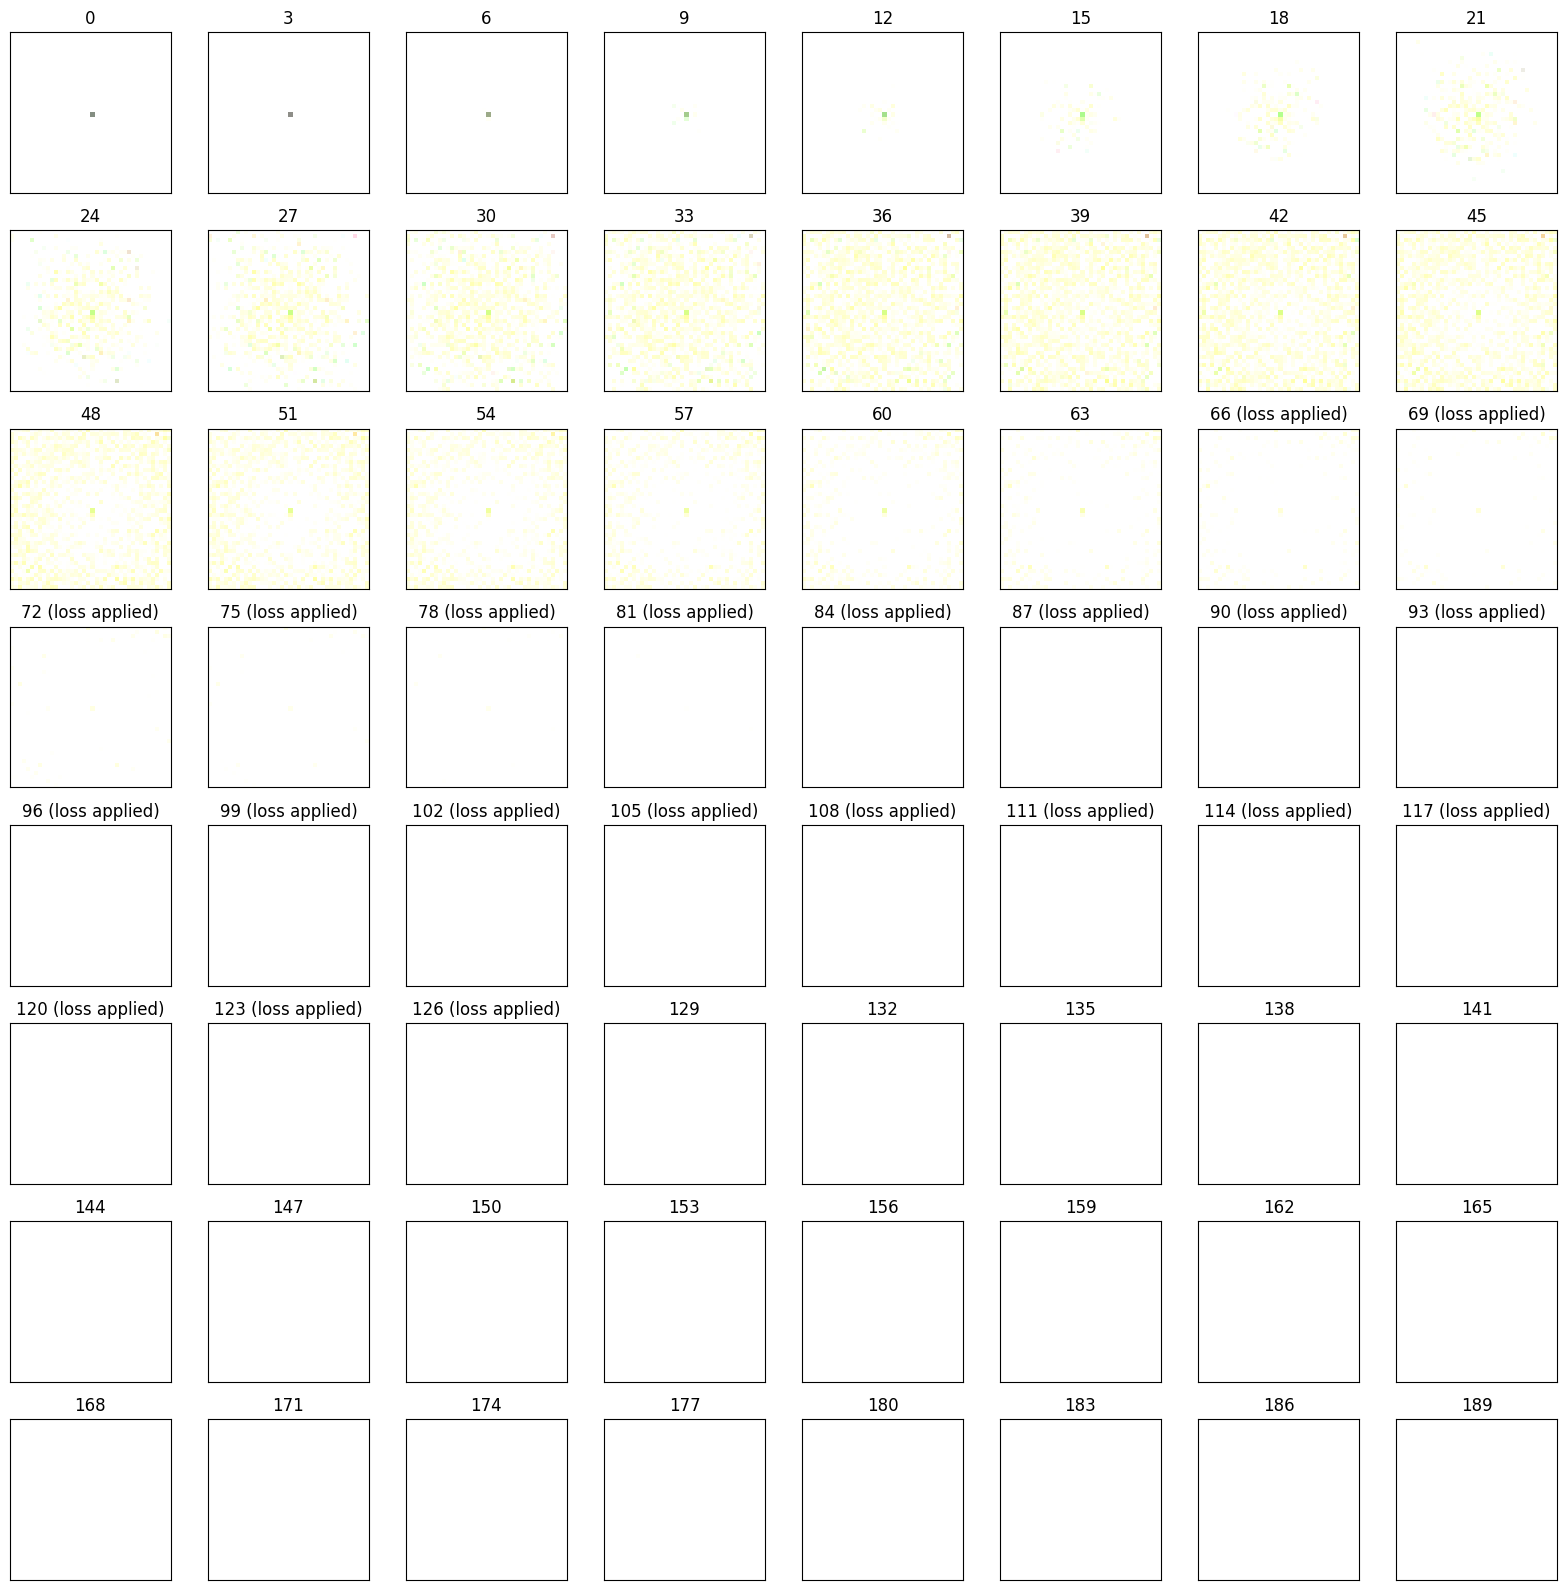

In [ ]:
def zoom(x, k=12):
  return x[...,k:-k,k:-k]

def to_rgb(x):
  rgb, a = x[..., :3,:,:], x[..., 3:4,:,:].clip(0, 1)
  # dead_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) <= 0.1
  # dead = dead_mask(alpha=a)
  # return np.clip(1.0-a+(rgb+0.5), 0.0, 1.0)
  # return np.clip(rgb+0.5+1.0*dead, 0, 1)
  return np.clip(1-a+rgb+0.5, 0, 1)      # adds mask so all cells that are transparent become white
  # return np.clip(rgb+0.5, 0.0,1.0)

# Visualize the dynamics of our learned CA
data = get_dataset()
init_state = model.seed(1, args.canvas_sz)

plot_every = 3
frames = model.cpu()(init_state, 200).detach().numpy()
frames = zoom(to_rgb(frames))[::plot_every]

rows, cols = 8, 8
fig = plt.figure(figsize=[2*cols, 2*rows], dpi=100)
for i in range(rows):
  for j in range(cols):
    ix = 1 + i*cols + j
    if frames.shape[0] >= ix:
      plt.subplot(rows,cols,ix)
      plt.xticks([],[]) ; plt.yticks([],[])
      plt.title(plot_every*(ix-1))
      if plot_every*(ix-1) > args.num_steps[0] and plot_every*(ix-1) < args.num_steps[1]:
        plt.title('{} (loss applied)'.format(plot_every*(ix-1)))
      plt.imshow(frames[ix-1,0].transpose(1,2,0).clip(0,1))

plt.tight_layout() ; plt.show()

In [ ]:
# Construct a video of our CA's growth
init_state = model.seed(1, args.canvas_sz)

frames = model.cpu()(init_state, 200).detach().numpy()
frames = zoom(to_rgb(frames)).squeeze(1)  # output has axes [time, rgb, width, height]
frames = frames.transpose(0,2,3,1)

path = 'video.mp4'
make_video(frames, path=path)


# Plot the video below this cell
print('\n', path)
mp4 = open(path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


 video.mp4
